In [135]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from typing import Callable

pd.set_option("display.max.columns", 50)
pd.set_option("precision", 1)
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
DATADIR = os.path.join("..", "data")
LOGDIR = os.path.join("..", "logs")

strategies = [
    "naive_random",
    "greedy_random",
    "greedy_eigenvector",
    "greedy_diameter"
]

In [142]:
#Parse tables and reduce the simul data a bit and engineer a few features of the summaries

results = pd.read_pickle(os.path.join(DATADIR, "simul_results", "second_batch.pkl"))
results = (
    results
    .groupby(["strategy", "group"]).mean()
    .loc[:, lambda df: df.columns.get_level_values(1).isin([0.25, 1.0])]
    .unstack(level=0)
    .loc[:, lambda df: df.columns.get_level_values(2).isin(strategies)]
)

results.columns = results.columns.to_flat_index()
results.columns = [f"{x[0]}_{str(x[1])}_{x[2]}" for x in results.columns]
results = results.reset_index().rename({"group": "name"}, axis=1)


summaries = pd.read_pickle(os.path.join(DATADIR, "processed_data", "network_summaries.pkl"))
summaries["density"] = summaries.degree_mean / (summaries.nodes - 1)
summaries["eig_cent_range"] = summaries.eig_cent_max - summaries.eig_cent_min
summaries["eig_cent_ratio"] = summaries.eig_cent_max / summaries.eig_cent_min
summaries["eig_cent_logratio"] = np.log(summaries["eig_cent_ratio"])
summaries["degree_range"] = summaries.degree_max - summaries.degree_min
summaries["degree_ratio"] = summaries.degree_max / summaries.degree_min
summaries = summaries.drop(index=6)

#Merge together
summaries = pd.merge(summaries, results, on=["name"]).set_index("name")


#Helper histogram explore function
def explore_hist(
    col:str, 
    filter_func:Callable = None, 
    df:pd.DataFrame = summaries, 
    ascending:bool = False
    ):
    df[col].plot(kind='hist', subplots=True, title=col)
    if filter_func == None:
        filter_func = lambda x: x[col] > 0
    print(df[filter_func].sort_values(by=col, ascending=ascending)[col])

In [143]:
summaries.describe()

,nodes,edges,degree_mean,degree_max,degree_min,diameter,triangles,average_clustering,eig_cent_mean,eig_cent_max,eig_cent_min,density,eig_cent_range,eig_cent_ratio,eig_cent_logratio,degree_range,degree_ratio,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,caught_rel_0.25_greedy_eigenvector,caught_rel_0.25_greedy_random,caught_rel_0.25_naive_random,caught_rel_1.0_greedy_eigenvector,caught_rel_1.0_greedy_random,caught_rel_1.0_naive_random,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
count,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,1.7e+01,17.0,1.7e+01,1.7e+01,1.7e+01,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0
mean,63.2,244.1,6.0,25.9,1.2,5.2,45535.5,0.5,1.1e-01,0.4,1.6e-02,1.1e-01,4.0e-01,6821.4,4.4,24.6,21.8,81.1,80.7,113.7,382.8,382.3,409.0,18.0,18.2,27.1,382.8,382.3,409.0,63.3,61.2,92.3,382.8,382.3,409.0
std,42.0,387.3,5.3,19.5,0.8,1.8,156296.7,0.2,4.4e-02,0.1,1.8e-02,7.2e-02,9.9e-02,27663.7,2.3,19.0,15.1,41.7,41.7,65.3,245.2,245.9,249.9,16.1,16.1,34.0,245.2,245.9,249.9,64.8,58.2,78.4,245.2,245.9,249.9
min,18.0,27.0,2.2,9.0,1.0,2.0,3.0,0.1,3.6e-02,0.2,2.8e-06,3.4e-02,2.3e-01,7.2,2.0,8.0,9.0,28.8,30.2,36.0,107.0,107.0,116.2,4.4,4.9,4.2,107.0,107.0,116.2,23.8,25.9,29.4,107.0,107.0,116.2
25%,33.0,50.0,3.5,15.0,1.0,4.0,35.0,0.4,7.6e-02,0.3,1.5e-03,7.1e-02,3.2e-01,18.6,2.9,14.0,13.0,53.2,54.2,67.7,229.8,226.9,242.6,7.8,8.6,9.8,229.8,226.9,242.6,33.6,32.2,50.4,229.8,226.9,242.6
50%,51.0,93.0,3.7,17.0,1.0,5.0,57.0,0.4,1.1e-01,0.4,7.2e-03,9.0e-02,4.2e-01,53.2,4.0,16.0,17.0,61.5,62.4,84.7,274.3,272.9,280.2,11.3,10.9,14.2,274.3,272.9,280.2,47.2,49.9,67.8,274.3,272.9,280.2
75%,78.0,312.0,5.0,25.0,1.0,6.0,4321.0,0.6,1.4e-01,0.5,2.7e-02,1.2e-01,4.6e-01,223.7,5.4,23.0,20.0,103.2,98.6,139.2,413.5,412.2,439.1,22.2,22.7,22.6,413.5,412.2,439.1,58.0,58.4,91.4,413.5,412.2,439.1
max,151.0,1619.0,21.4,75.0,4.0,10.0,646230.0,0.8,2.0e-01,0.6,6.3e-02,3.0e-01,5.7e-01,114171.3,11.6,71.0,60.0,177.2,176.2,252.2,906.8,906.5,929.5,57.7,59.0,132.1,906.8,906.5,929.5,304.7,278.6,364.8,906.8,906.5,929.5


In [144]:
summaries

,nodes,edges,degree_mean,degree_max,degree_min,diameter,triangles,average_clustering,eig_cent_mean,eig_cent_max,eig_cent_min,density,eig_cent_range,eig_cent_ratio,eig_cent_logratio,degree_range,degree_ratio,caught_proportion_0.25_greedy_eigenvector,caught_proportion_0.25_greedy_random,caught_proportion_0.25_naive_random,caught_proportion_1.0_greedy_eigenvector,caught_proportion_1.0_greedy_random,caught_proportion_1.0_naive_random,caught_rel_0.25_greedy_eigenvector,caught_rel_0.25_greedy_random,caught_rel_0.25_naive_random,caught_rel_1.0_greedy_eigenvector,caught_rel_1.0_greedy_random,caught_rel_1.0_naive_random,eigen_proportion_0.25_greedy_eigenvector,eigen_proportion_0.25_greedy_random,eigen_proportion_0.25_naive_random,eigen_proportion_1.0_greedy_eigenvector,eigen_proportion_1.0_greedy_random,eigen_proportion_1.0_naive_random
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
togo,33,47,2.8,19,1,4,14,0.5,1.4e-01,0.6,3.2e-02,8.9e-02,0.6,18.6,2.9,18,19.0,61.1,62.4,74.6,274.3,272.9,277.2,4.7,5.6,5.3,274.3,272.9,277.2,31.4,32.0,47.7,274.3,272.9,277.2
mali_terrorists,36,67,3.7,11,1,7,43,0.4,1.2e-01,0.4,7.2e-03,1.1e-01,0.4,53.2,4.0,10,11.0,52.7,55.2,67.7,267.7,265.3,279.4,9.1,9.2,9.8,267.7,265.3,279.4,47.2,50.1,63.4,267.7,265.3,279.4
london_gang,54,315,11.7,25,2,4,4321,0.6,1.1e-01,0.2,8.8e-03,2.2e-01,0.2,28.4,3.3,23,12.5,53.7,52.3,81.9,190.6,194.3,228.7,38.8,36.5,54.8,190.6,194.3,228.7,42.7,41.5,67.8,190.6,194.3,228.7
Islamic_state_group,25,27,2.2,9,1,4,3,0.1,1.6e-01,0.5,4.4e-02,9.0e-02,0.5,12.4,2.5,8,9.0,53.2,54.2,59.0,223.1,231.6,229.1,4.4,4.9,4.2,223.1,231.6,229.1,31.1,31.0,33.8,223.1,231.6,229.1
heroin_natarjan,38,87,4.6,20,1,4,46,0.4,1.4e-01,0.4,3.3e-02,1.2e-01,0.4,12.9,2.6,19,20.0,58.2,58.6,81.4,235.2,239.7,272.4,14.8,15.0,17.6,235.2,239.7,272.4,42.4,43.3,65.3,235.2,239.7,272.4
italian_gangs,65,113,3.5,21,1,6,57,0.4,9.3e-02,0.4,6.9e-03,5.4e-02,0.4,63.6,4.2,20,21.0,103.2,105.4,139.2,501.0,495.0,532.2,11.1,9.7,11.8,501.0,495.0,532.2,49.8,56.7,91.4,501.0,495.0,532.2
cocaine_mambo,31,58,3.7,15,1,4,35,0.4,1.4e-01,0.5,2.0e-02,1.2e-01,0.4,23.6,3.2,14,15.0,48.5,47.0,64.4,229.8,225.8,242.6,11.3,10.9,12.5,229.8,225.8,242.6,33.6,32.2,50.4,229.8,225.8,242.6
cocaine_jake,38,50,2.6,12,1,4,15,0.1,1.2e-01,0.5,2.7e-02,7.1e-02,0.4,16.6,2.8,11,12.0,68.4,67.2,84.7,336.0,334.3,341.9,7.3,6.3,7.3,336.0,334.3,341.9,41.9,40.5,54.6,336.0,334.3,341.9
17Nov_greece,18,46,5.1,17,1,2,940,0.7,2.0e-01,0.4,6.3e-02,3.0e-01,0.4,7.2,2.0,16,17.0,28.8,30.2,36.0,107.0,107.0,116.2,11.3,11.5,14.2,107.0,107.0,116.2,23.8,25.9,29.4,107.0,107.0,116.2


Based on Measures of density: we see that the most dense are ndrangheta_mafia, 17Nov_greece, noordin and london. Al Qaeda is really just middle of the pack

name
17Nov_greece    0.3
london_gang     0.2
noordin_top     0.2
Name: density, dtype: float64


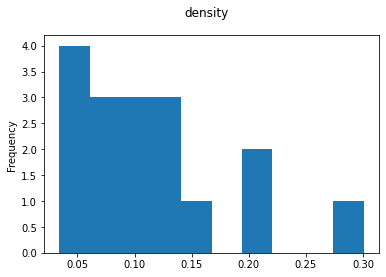

In [145]:
explore_hist("density", lambda x: x["density"] > 0.2)

name
ndrangheta_mafia    0.8
17Nov_greece        0.7
noordin_top         0.7
london_gang         0.6
al_qaeda            0.6
Name: average_clustering, dtype: float64


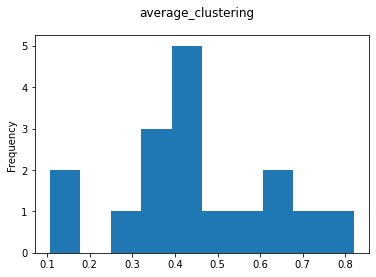

In [146]:
explore_hist("average_clustering", lambda x: x["average_clustering"] > 0.5)

Exploring the eigenvalues. Nov Greece is a bit higher than everyone else in terms of mean. Al Qaeda is bottom of the barrel for mean eigenvector centrality. It also has the lowest minimum eigenvector centrality and an astronomical ratio between max and min. This is likely its success considering especially how we are calculating success. A number of networks are also obviously in an upper echeclon of ratios. 

name
17Nov_greece           2.0e-01
cocaine_acero          1.6e-01
Islamic_state_group    1.6e-01
cocaine_mambo          1.4e-01
togo                   1.4e-01
heroin_natarjan        1.4e-01
mali_terrorists        1.2e-01
cocaine_jake           1.2e-01
london_gang            1.1e-01
noordin_top            9.4e-02
cocaine_juanes         9.4e-02
italian_gangs          9.3e-02
911_hijackers          7.6e-02
caviar                 6.5e-02
ndrangheta_mafia       6.1e-02
montagna               5.8e-02
al_qaeda               3.6e-02
Name: eig_cent_mean, dtype: float64


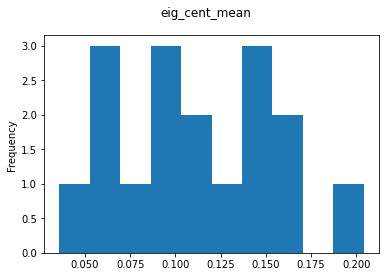

In [147]:
explore_hist("eig_cent_mean")

name
al_qaeda            11.6
cocaine_juanes       5.9
ndrangheta_mafia     5.7
911_hijackers        5.6
caviar               5.4
montagna             5.3
noordin_top          5.2
Name: eig_cent_logratio, dtype: float64


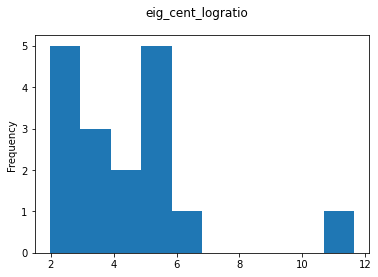

In [149]:
explore_hist("eig_cent_logratio", lambda x: x["eig_cent_logratio"] > 5)

In [ ]:
#Quick and dirty log transform
plt.hist(np.log(np.array(summaries["eig_cent_ratio"].to_list())))

                   name  eig_cent_max
0                  togo         0.603
3   Islamic_state_group         0.541
10               caviar         0.529
14        cocaine_acero         0.510
7         cocaine_mambo         0.470
13       cocaine_juanes         0.464
8          cocaine_jake         0.451
9          17Nov_greece         0.449
5         italian_gangs         0.439
12        911_hijackers         0.439
4       heroin_natarjan         0.427
1       mali_terrorists         0.382
11             al_qaeda         0.322
17             montagna         0.318
15          noordin_top         0.275
2           london_gang         0.249
16     ndrangheta_mafia         0.226


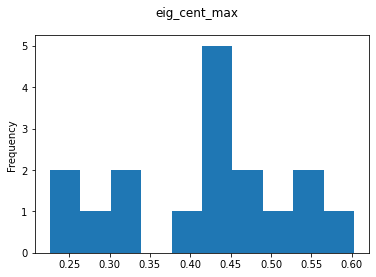

In [31]:
explore_hist("eig_cent_max")

                name  eig_cent_min
2        london_gang         0.009
1    mali_terrorists         0.007
5      italian_gangs         0.007
10            caviar         0.002
12     911_hijackers         0.002
17          montagna         0.002
13    cocaine_juanes         0.001
15       noordin_top         0.001
16  ndrangheta_mafia         0.001
11          al_qaeda         0.000


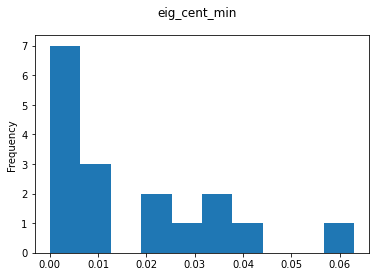

In [51]:
explore_hist("eig_cent_min", lambda x: x["eig_cent_min"] < 0.01)

Al qaeda is really just middle of the pack more or less in mean degree. Ndrangheta mafia is a claer high along wiht noordin and london gang. Note that although al qaeda has astronomical eigenvector centrality ratio it does not have a really high degree ratio. 

                name  degree_mean
16  ndrangheta_mafia         21.4
15       noordin_top         16.0
2        london_gang         11.7
9       17Nov_greece          5.1
11          al_qaeda          5.0


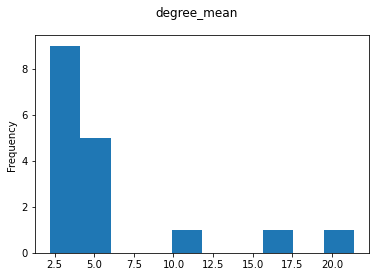

In [50]:
explore_hist("degree_mean", lambda x: x["degree_mean"] > 4.9)

                   name  degree_max
16     ndrangheta_mafia          75
10               caviar          60
15          noordin_top          55
17             montagna          40
2           london_gang          25
5         italian_gangs          21
4       heroin_natarjan          20
0                  togo          19
11             al_qaeda          17
9          17Nov_greece          17
13       cocaine_juanes          16
12        911_hijackers          15
7         cocaine_mambo          15
14        cocaine_acero          13
8          cocaine_jake          12
1       mali_terrorists          11
3   Islamic_state_group           9


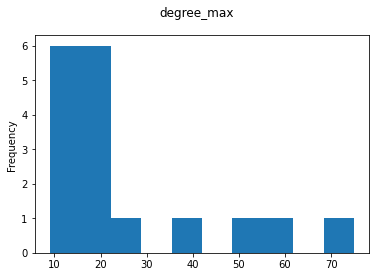

In [52]:
explore_hist("degree_max")

           name  degree_ratio
10       caviar          60.0
15  noordin_top          55.0
17     montagna          40.0


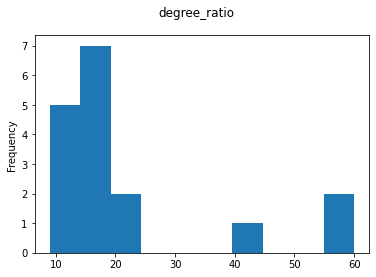

In [56]:
explore_hist("degree_ratio", lambda x: x["degree_ratio"] > 25)

                name  degree_range
16  ndrangheta_mafia            71
10            caviar            59
15       noordin_top            54
17          montagna            39


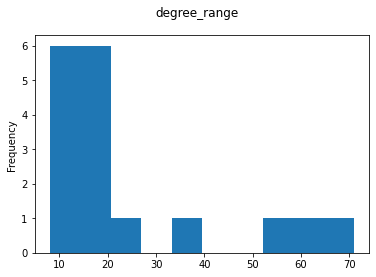

In [57]:
explore_hist("degree_range", lambda x: x["degree_range"] > 30)

Clear importance here of high diameter of al_qaeda I would say

               name  diameter
11         al_qaeda        10
1   mali_terrorists         7
12    911_hijackers         7
13   cocaine_juanes         7
5     italian_gangs         6
17         montagna         6


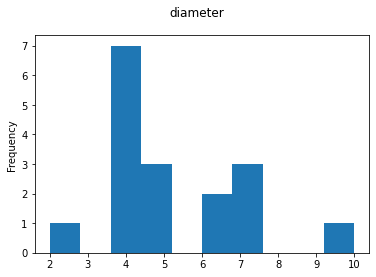

In [59]:
explore_hist("diameter", lambda x: x["diameter"] >= 6)